### Load Modules

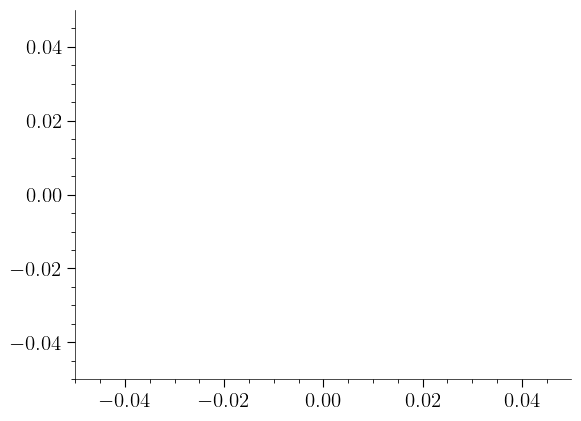

In [1]:
# Restart the kernel
import os
import dill as pickle
current_dir ='../../'
os.chdir(current_dir)

from src.codes.basic import *
from src.codes.utils.plot_utils_v2 import TwoDPlot as plot
from src.codes.utils.rom_utils import *
import time as time

import src.codes.prob_classes.base_class_heat_conduction_AM as bc
# from src.codes.prob_classes.base_class_heat_conduction_AM import ROM_simulation 
import src.codes.reductor.rom_class_AM as rom_class
from src.codes.algorithms.ecsw_t_AM import ecsw_red
import src.codes.algorithms.deim as deim_module

from importlib import reload

In [2]:
reload(bc)
reload(rom_class)

<module 'src.codes.reductor.rom_class_AM' from 'c:\\Users\\suparnob\\OneDrive - Texas A&M University\\Academic\\TAMU_MATERIALS\\POSTDOC\\HYPERREDUCTION\\SUPARNO\\HYPERREDUCTION__TAMIDS\\pyHyperRom\\src\\codes\\reductor\\rom_class_AM.py'>

### Load data

In [3]:
filename_dataC = 'tests/TwoD_heat_conduction_AM/data/DataClass_AM.dill'
with open(filename_dataC, 'rb') as f:
    Data_cls = pickle.load(f)

In [4]:
# load required variables from data
FOS = Data_cls.FOS
d = FOS.data
mask = d.mask
param_list = np.asarray(Data_cls.param_list)
NLS = np.asarray(Data_cls.NL_solutions)
K_mus = Data_cls.K_mus
t = Data_cls.t
q_mus = Data_cls.q_mus

# train_mask, test_mask = Data_cls.train_mask, Data_cls.test_mask 

_,N_snap = np.shape(NLS[0])
print(N_snap)

2501


## ECSW Hyper-reduction

### Train-Test split

In [5]:
Snap_sel=900
train_mask, _ = train_test_split_sobol(N_snap, N_sel=Snap_sel)

### Data-processing

In [6]:
NLS_mask = NLS[0][mask]
NLS_train = NLS_mask[:,train_mask]

### Plot snapshots

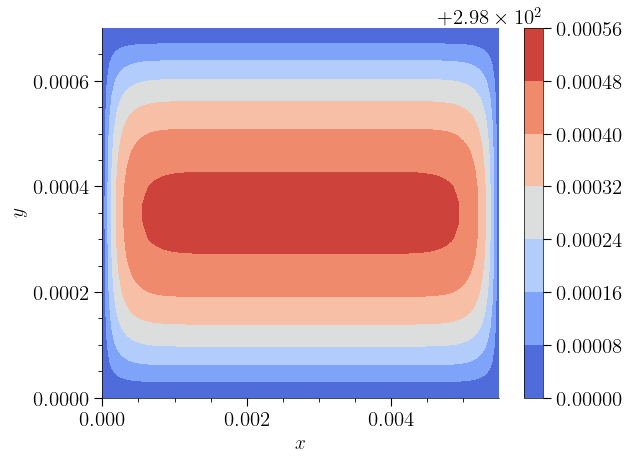

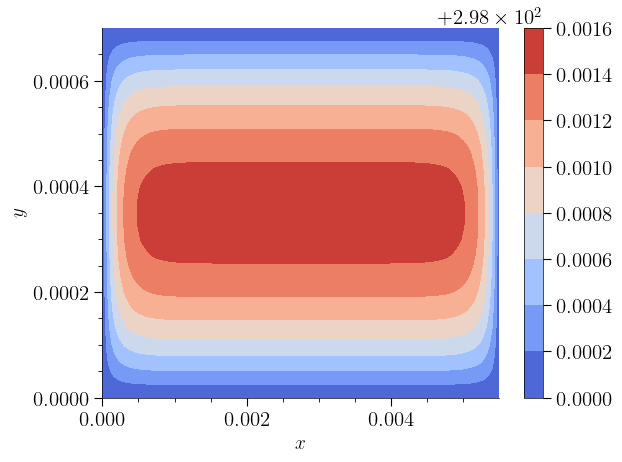

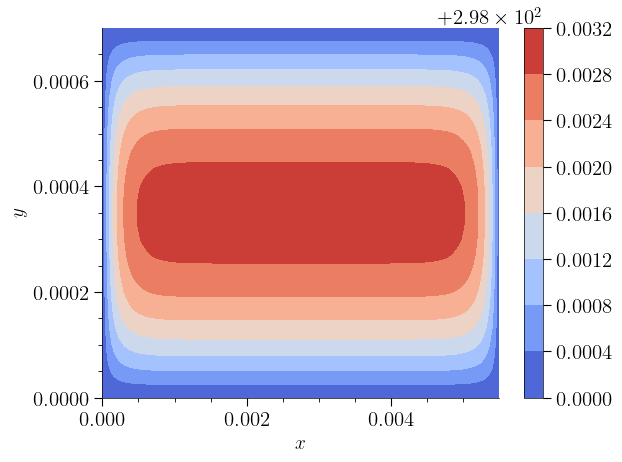

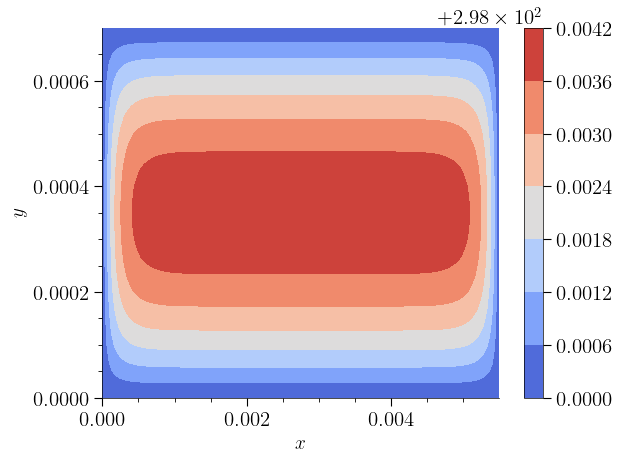

In [7]:
NLS_train_plot = NLS[0][:,train_mask]

for i in range(4):
    Plot = plot(d.xi[0], d.xi[1], NLS_train_plot[:,i])
    Plot.contour_()
# plt.show()


#### Step 1: Perform SVD on the snapshots (calculate $\mathbb{V}(=\mathbb{W}$)):

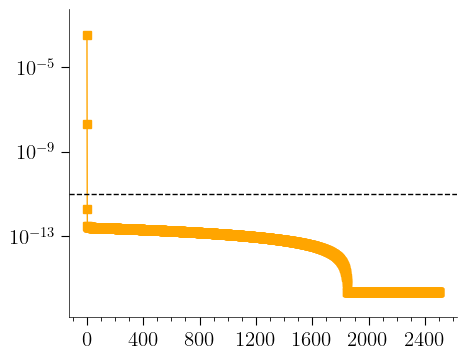

Number of modes selected: 3


In [8]:
plt.rcParams['figure.dpi'] = 100
n_sel, U = svd_mode_selector(NLS_mask.T, tolerance=1e-11,modes=True)
V_sel = U[:, :n_sel]

### Step 2: Perform NNLS for ECSW

In [9]:
_,N_snap_train = np.shape(NLS_train)
tol = None

In [10]:
tic_h_setup_b = time.time()

xi, residual = ecsw_red(d, V_sel, d.Le, K_mus, q_mus, n_sel, N_snap_train, d.mask, NLS_train, tol=tol)

toc_h_setup_b = time.time()

norm of rhs: 2221.6107387255765


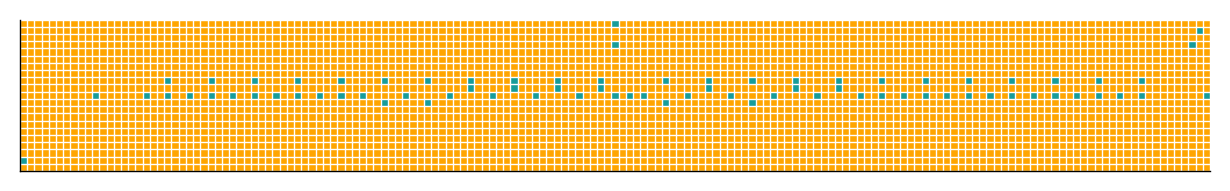

Fraction of total elements active in the ROM: 2.2510822510822512%
residual=3.352798973468844e-16


In [11]:
plt.rcParams['figure.dpi'] = 200
plot(0,0,0).element_((d.ncells[0],d.ncells[1]), xi, d.ncells)
print(f"Fraction of total elements active in the ROM: {len(xi[xi>0])*100/len(xi)}%")
print(f"{residual=}")

In [12]:
Data_cls.FOS.data.n_verts

3652

In [13]:
# ### DEIM
# # Force snapshots
# F_nl = np.asarray(Data_cls.rhs[0])
# deim = deim_module.deim(d,F_nl.T,train_mask,param_list,V_sel,NLS_train,d.mask,tol_f=1e-6, extra_modes=0)
# tic_h_setup_b = time.time()
# deim.select_elems()
# toc_h_setup_b = time.time()

# xi = deim.xi

# plot(0,0,0).element_((d.ncells[0],d.ncells[1]), xi, d.ncells)
# print(f"Fraction of total elements active in the ROM: {len(xi[xi>0])*100/len(xi)}%")
# # print(f"{residual=}")


### ROM Simulation

In [14]:
ROM_h = bc.ROM_simulation(Data_cls, V_sel, xi, sol_init_guess=298.0) #, N_rom_snap=1)
ROM_h.run_simulation()

c:\Users\suparnob\AppData\Local\anaconda3\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:394: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
c:\Users\suparnob\AppData\Local\anaconda3\Lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:285: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


In [15]:
ROM = bc.ROM_simulation(Data_cls, V_sel, sol_init_guess=298.0) #, xi=xi)#, N_rom_snap=1)
ROM.run_simulation()

### Performance Statistics

In [16]:
NLS_rom_h = np.asarray(ROM_h.NL_solutions_rom[0])
ROM_speed_up_h = ROM_h.speed_up
print(ROM_speed_up_h)

[58.311627460109825]


In [17]:
NLS_rom = np.asarray(ROM.NL_solutions_rom[0])
ROM_speed_up = ROM.speed_up
print(ROM_speed_up)

[5.40275395292381]


In [18]:
err= np.linalg.norm(NLS_rom-NLS[0])/np.linalg.norm(NLS[0]-298)
print(err)

3.2738772297962374e-09


In [19]:
a=25

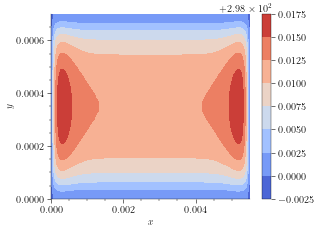

In [20]:
plt.rcParams['figure.dpi'] = 50
Plot = plot(d.xi[0], d.xi[1], NLS_rom_h[:,a])
Plot.contour_()

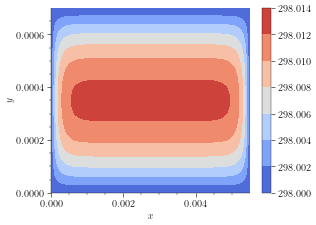

In [21]:
Plot = plot(d.xi[0], d.xi[1], NLS_rom[:,a])
Plot.contour_()

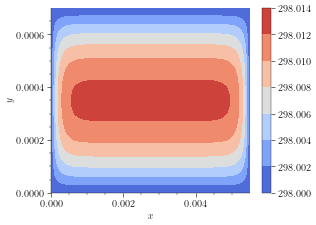

In [22]:
Plot = plot(d.xi[0], d.xi[1], NLS[0][:,a])
Plot.contour_()

In [23]:
# ROM_SOL = ROM.NL_solutions_rom[0]
# fig, ax = plt.subplots(figsize=(5,3.5))

# for i in range(Snap_sel*10):
#     Plot = plot(d.xi[0], ROM_SOL[0][::2,i], ax=ax)
#     Plot.line_()

# plt.show()